# **Computation of PPP Metrics for Control Run**

**Important metrics:**

- SH sea ice extent/volume
- regional sea ice extent/volume
- regional NPP, PCO2, SSS, SST
- gridpoint-level fields for sea ice concentration, SST, SSS, NPP, PCO2
- ~~sea ice edge position (latitude at which sea ice concentration drops below 15%)~~

In [1]:
import os
import warnings
warnings.filterwarnings("ignore", message="invalid value encountered in true_divide")
warnings.filterwarnings("ignore", message="Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range")
warnings.filterwarnings("ignore", message="invalid value encountered in reduce")

import xarray as xr
import numpy as np
import math
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
import hmei.processing as pcs
import hmei.visualization as vis

# Import Raw Data

In [2]:
write_rootdir = '/home/bbuchovecky/storage/so_predict_derived/'
rootdir = '/home/bbuchovecky/storage/so_predict_derived/'
reg_masks = xr.open_dataset(write_rootdir+'regional_global_masks.nc')

In [3]:
## variable names
CN_INV = 'CN_INV'
NPP = 'NPP'
PCO2SURF = 'PCO2SURF'
SIE = 'SIE'
SIV = 'SIV'
SI_EDGE = 'SI_EDGE'
SSS = 'SSS'
SST = 'SST'
MLD ='MLD'

In [5]:
sst_raw = pcs.open_raw_ctrl(SST)

/local/projects/so_predict/esm2m_froelicher/CTRL/SST/sst_*.nc


In [6]:
sss_raw = pcs.open_raw_ctrl(SSS)

/local/projects/so_predict/esm2m_froelicher/CTRL/SSS/sss_*.nc


In [7]:
pco2_raw = pcs.open_raw_ctrl(PCO2SURF)

/local/projects/so_predict/esm2m_froelicher/CTRL/PCO2SURF/pco2surf_*.nc


In [8]:
npp_raw = pcs.open_raw_ctrl(NPP)

/local/projects/so_predict/esm2m_froelicher/CTRL/NPP/NPP_*.nc


In [9]:
cn_raw = pcs.open_raw_ctrl(CN_INV)

/local/projects/so_predict/esm2m_froelicher/CTRL/CN/CN_inv_*.nc


In [10]:
mld_raw = pcs.open_raw_ctrl(MLD)

/local/projects/so_predict/esm2m_froelicher/CTRL/MLD/mld_0*.nc


In [11]:
sie_raw = pcs.open_gridcell_ctrl(SIE)

/home/bbuchovecky/storage/so_predict_derived/CTRL/SIE/sie_ctrl_so_timeseries.nc


In [12]:
siv_raw = pcs.open_gridcell_ctrl(SIV)

/home/bbuchovecky/storage/so_predict_derived/CTRL/SIV/siv_ctrl_so_timeseries.nc


# ANNUAL

## Annual Mean
For each year, the area-weighted mean value for the specified region.

### Global

In [13]:
## global annual mean

sst_global_annual_mean = pcs.reg_annual_mean(sst_raw, 'sst') - 273.15
sss_global_annual_mean = pcs.reg_annual_mean(sss_raw, 'sss')
pco2_global_annual_mean = pcs.reg_annual_mean(pco2_raw, 'pco2surf')
npp_global_annual_mean = pcs.reg_annual_mean(npp_raw, 'NPP')
cn_global_annual_mean = pcs.reg_annual_mean(cn_raw, 'CN_INV')
# sie_global_annual_mean = pcs.reg_annual_mean(sie_raw, 'SIE_area')
# siv_global_annual_mean = pcs.reg_annual_mean(siv_raw, 'SIV_area')
mld_global_annual_mean = pcs.reg_annual_mean(mld_raw, 'mld')

In [14]:
regions = sst_global_annual_mean.data_vars

for reg in regions:
    sst_global_annual_mean[reg].attrs['label'] = 'Sea surface temperature ($^{\circ}$C)'
    sss_global_annual_mean[reg].attrs['label'] = 'Sea surface salinity (psu)'
    pco2_global_annual_mean[reg].attrs['label'] = 'Surface pCO$_{2}$ (uatm)'
    npp_global_annual_mean[reg].attrs['label'] = 'Net primary production'
    cn_global_annual_mean[reg].attrs['label'] = 'Sea ice concentration'
#     sie_global_annual_mean[reg].attrs['label'] = 'Sea ice extent (m$^{2}$)'
#     siv_global_annual_mean[reg].attrs['label'] = 'Sea ice volume (m$^{3}$)'
    mld_global_annual_mean[reg].attrs['label'] = 'Mixed-layer depth (m)'

In [15]:
write_rootdir = '/home/bbuchovecky/storage/so_predict_derived/'
subdir_ctrl = 'CTRL/'

## save mean data
def save_mean(ds, var, reg, time_scale):
    filename = var.lower()+'_ts_'+reg.lower()+'_'+time_scale.lower()+'_mean.nc'
    ds.to_netcdf(write_rootdir+subdir_ctrl+var.upper()+'/'+filename)

save_mean(sst_global_annual_mean, 'sst', 'global', 'annual')
save_mean(sss_global_annual_mean, 'sss', 'global', 'annual')
save_mean(pco2_global_annual_mean, 'pco2surf', 'global', 'annual')
save_mean(npp_global_annual_mean, 'npp', 'global', 'annual')
save_mean(cn_global_annual_mean, 'cn_inv', 'global', 'annual')
# save_mean(sie_global_annual_mean, 'sie', 'global', 'annual')
# save_mean(siv_global_annual_mean, 'siv', 'global', 'annual')
save_mean(mld_global_annual_mean, 'mld', 'global', 'annual')

### Southern Ocean Regions

In [16]:
## Southern Ocean annual mean

sst_so_annual_mean  = []
sss_so_annual_mean  = []
pco2_so_annual_mean = []
npp_so_annual_mean  = []
cn_so_annual_mean   = []
sie_so_annual_mean  = []
siv_so_annual_mean  = []
mld_so_annual_mean = []

for reg in reg_masks.data_vars:
    sst_so_annual_mean.append(pcs.reg_annual_mean(sst_raw, 'sst', reg_masks, reg) - 273.15)
    sss_so_annual_mean.append(pcs.reg_annual_mean(sss_raw, 'sss', reg_masks, reg))
    pco2_so_annual_mean.append(pcs.reg_annual_mean(pco2_raw, 'pco2surf', reg_masks, reg))
    npp_so_annual_mean.append(pcs.reg_annual_mean(npp_raw, 'NPP', reg_masks, reg))
    cn_so_annual_mean.append(pcs.reg_annual_mean(cn_raw, 'CN_INV', reg_masks, reg))
    sie_so_annual_mean.append(pcs.reg_annual_mean(sie_raw, 'SIE_area', reg_masks, reg))
    siv_so_annual_mean.append(pcs.reg_annual_mean(siv_raw, 'SIV_area', reg_masks, reg))
    mld_so_annual_mean.append(pcs.reg_annual_mean(mld_raw, 'mld', reg_masks, reg))

In [17]:
## rename DataArrays to regional names (SouthernOcean, Weddell, etc.)

so_annual_mean = zip(sst_so_annual_mean,sss_so_annual_mean,pco2_so_annual_mean,npp_so_annual_mean,
                       cn_so_annual_mean,sie_so_annual_mean,siv_so_annual_mean,mld_so_annual_mean)

for (sst,sss,pco2,npp,cn,sie,siv,mld) in so_annual_mean:
    sst.name = sst.name.split('_')[0]
    sss.name = sss.name.split('_')[0]
    pco2.name = pco2.name.split('_')[0]
    npp.name = npp.name.split('_')[0]
    cn.name = cn.name.split('_')[0]
    sie.name = sie.name.split('_')[0]
    siv.name = siv.name.split('_')[0]
    mld.name = mld.name.split('_')[0]

In [18]:
## create Dataset

ds_sst_annual_mean = xr.merge(sst_so_annual_mean)
ds_sss_annual_mean = xr.merge(sss_so_annual_mean)
ds_pco2_annual_mean = xr.merge(pco2_so_annual_mean)
ds_npp_annual_mean = xr.merge(npp_so_annual_mean)
ds_cn_annual_mean = xr.merge(cn_so_annual_mean)
ds_sie_annual_mean = xr.merge(sie_so_annual_mean)
ds_siv_annual_mean = xr.merge(siv_so_annual_mean)
ds_mld_annual_mean = xr.merge(mld_so_annual_mean)

In [19]:
## set names

ds_sst_annual_mean.attrs['name'] = 'sst_so_annual_mean'
ds_sss_annual_mean.attrs['name'] = 'sss_so_annual_mean'
ds_pco2_annual_mean.attrs['name'] = 'pco2surf_so_annual_mean'
ds_npp_annual_mean.attrs['name'] = 'npp_so_annual_mean'
ds_cn_annual_mean.attrs['name'] = 'sic_so_annual_mean'
ds_sie_annual_mean.attrs['name'] = 'sie_so_annual_mean'
ds_siv_annual_mean.attrs['name'] = 'siv_so_annual_mean'
ds_mld_annual_mean.attrs['name'] = 'mld_so_annual_mean'

In [20]:
regions = ds_sst_annual_mean.data_vars

for reg in regions:
    ds_sst_annual_mean[reg].attrs['label'] = 'Sea surface temperature ($^{\circ}$C)'
    ds_sss_annual_mean[reg].attrs['label'] = 'Sea surface salinity (psu)'
    ds_pco2_annual_mean[reg].attrs['label'] = 'Surface pCO$_{2}$ (uatm)'
    ds_npp_annual_mean[reg].attrs['label'] = 'Net primary production'
    ds_cn_annual_mean[reg].attrs['label'] = 'Sea ice concentration'
    ds_sie_annual_mean[reg].attrs['label'] = 'Sea ice extent (m$^{2}$)'
    ds_siv_annual_mean[reg].attrs['label'] = 'Sea ice volume (m$^{3}$)'
    ds_mld_annual_mean[reg].attrs['label'] = 'Mixed-layer depth (m)'

In [21]:
## save Datasets as NetCDF files

write_rootdir = '/home/bbuchovecky/storage/so_predict_derived/'
subdir_ctrl = 'CTRL/'

## save mean data
def save_mean(ds, var, reg, time_scale):
    filename = var.lower()+'_'+reg.lower()+'_'+time_scale.lower()+'_mean.nc'
    ds.to_netcdf(write_rootdir+subdir_ctrl+var.upper()+'/'+filename)

save_mean(ds_sst_annual_mean, 'sst', 'so', 'annual')
save_mean(ds_sss_annual_mean, 'sss', 'so', 'annual')
save_mean(ds_pco2_annual_mean, 'pco2surf', 'so', 'annual')
save_mean(ds_npp_annual_mean, 'npp', 'so', 'annual')
save_mean(ds_cn_annual_mean, 'cn_inv', 'so', 'annual')
save_mean(ds_sie_annual_mean, 'sie', 'so', 'annual')
save_mean(ds_siv_annual_mean, 'siv', 'so', 'annual')
save_mean(ds_mld_annual_mean, 'mld', 'so', 'annual')

### SIE

In [4]:
reg_masks = xr.open_dataset('/home/bbuchovecky/storage/so_predict_derived/regional_global_masks.nc')
sie_raw = xr.open_dataset('/home/bbuchovecky/storage/so_predict_derived/CTRL/SIE/sie_gc_so_monthly_allmetrics.nc')

In [6]:
## GLOBAL
sie_global_annual = sie_raw['SIE_area'].groupby('time.year').mean(dim='time').sum(dim={'xt_ocean','yt_ocean'})
sie_global_annual.name = 'Global'
sie_global_annual = sie_global_annual.to_dataset()
sie_global_annual.attrs['name'] = 'sie_ts_global_annual_mean.nc'
sie_global_annual['Global'].attrs['label'] = 'Sea ice extent (m$^{2}$)'

sie_global_annual.to_netcdf('/home/bbuchovecky/storage/so_predict_derived/CTRL/SIE/sie_ts_global_annual_mean.nc')

In [7]:
## REGIONAL
sie_so_annual = []

for reg in reg_masks.data_vars:
    temp = sie_raw['SIE_area'].where(reg_masks[reg] == 1).groupby('time.year').mean(dim='time').sum(dim={'xt_ocean','yt_ocean'})
    temp.name = reg
    sie_so_annual.append(temp)

sie_so_annual = xr.merge(sie_so_annual)
for reg in reg_masks.data_vars:
    sie_so_annual[reg].attrs['label'] = 'Sea ice extent (m$^{2}$)'
sie_so_annual.attrs['name'] = 'sie_ts_so_annual_mean.nc'

sie_so_annual.to_netcdf('/home/bbuchovecky/storage/so_predict_derived/CTRL/SIE/sie_ts_so_annual_mean.nc')

### SIV

In [8]:
reg_masks = xr.open_dataset('/home/bbuchovecky/storage/so_predict_derived/regional_global_masks.nc')
siv_raw = xr.open_dataset('/home/bbuchovecky/storage/so_predict_derived/CTRL/SIV/siv_gc_so_monthly_allmetrics.nc')

In [9]:
## GLOBAL
siv_global_annual = siv_raw['SIV_area'].groupby('time.year').mean(dim='time').sum(dim={'xt_ocean','yt_ocean'})
siv_global_annual.name = 'Global'
siv_global_annual = siv_global_annual.to_dataset()
siv_global_annual.attrs['name'] = 'siv_ts_global_annual_mean.nc'
siv_global_annual['Global'].attrs['label'] = 'Sea ice volume (m$^{3}$)'

sie_global_annual.to_netcdf('/home/bbuchovecky/storage/so_predict_derived/CTRL/SIV/siv_ts_global_annual_mean.nc')

In [10]:
## REGIONAL
siv_so_annual = []

for reg in reg_masks.data_vars:
    temp = siv_raw['SIV_area'].where(reg_masks[reg] == 1).groupby('time.year').mean(dim='time').sum(dim={'xt_ocean','yt_ocean'})
    temp.name = reg
    siv_so_annual.append(temp)

siv_so_annual = xr.merge(siv_so_annual)
for reg in reg_masks.data_vars:
    siv_so_annual[reg].attrs['label'] = 'Sea ice volume (m$^{3}$)'
siv_so_annual.attrs['name'] = 'siv_ts_so_annual_mean.nc'

siv_so_annual.to_netcdf('/home/bbuchovecky/storage/so_predict_derived/CTRL/SIV/siv_ts_so_annual_mean.nc')

# MONTHLY

## Monthly Mean
For each month, the area-weighted mean value for the specified region.

### Global

In [22]:
## global monthly mean

sst_global_monthly_mean = pcs.reg_monthly_mean(sst_raw, 'sst') - 273.15
sss_global_monthly_mean = pcs.reg_monthly_mean(sss_raw, 'sss')
pco2_global_monthly_mean = pcs.reg_monthly_mean(pco2_raw, 'pco2surf')
npp_global_monthly_mean = pcs.reg_monthly_mean(npp_raw, 'NPP')
cn_global_monthly_mean = pcs.reg_monthly_mean(cn_raw, 'CN_INV')
sie_global_monthly_mean = pcs.reg_monthly_mean(sie_raw, 'SIE_area')
siv_global_monthly_mean = pcs.reg_monthly_mean(siv_raw, 'SIV_area')
mld_global_monthly_mean = pcs.reg_monthly_mean(mld_raw, 'mld')

In [23]:
regions = sst_global_monthly_mean.data_vars

for reg in regions:
    sst_global_monthly_mean[reg].attrs['label'] = 'Sea surface temperature anomaly ($^{\circ}$C)'
    sss_global_monthly_mean[reg].attrs['label'] = 'Sea surface salinity anomaly (psu)'
    pco2_global_monthly_mean[reg].attrs['label'] = 'Surface pCO$_{2}$ anomaly (uatm)'
    npp_global_monthly_mean[reg].attrs['label'] = 'Net primary production anomaly'
    cn_global_monthly_mean[reg].attrs['label'] = 'Sea ice concentration anomaly'
    sie_global_monthly_mean[reg].attrs['label'] = 'Sea ice extent anomaly (m$^{2}$)'
    siv_global_monthly_mean[reg].attrs['label'] = 'Sea ice volume anomaly (m$^{3}$)'
    mld_global_monthly_mean[reg].attrs['label'] = 'Mixed-layer depth anomaly (m)'

In [24]:
write_rootdir = '/home/bbuchovecky/storage/so_predict_derived/'
subdir_ctrl = 'CTRL/'

## save mean data
def save_mean(ds, var, reg, time_scale):
    filename = var.lower()+'_'+reg.lower()+'_'+time_scale.lower()+'_mean.nc'
    ds.to_netcdf(write_rootdir+subdir_ctrl+var.upper()+'/'+filename)

save_mean(sst_global_monthly_mean, 'sst', 'global', 'monthly')
save_mean(sss_global_monthly_mean, 'sss', 'global', 'monthly')
save_mean(pco2_global_monthly_mean, 'pco2surf', 'global', 'monthly')
save_mean(npp_global_monthly_mean, 'npp', 'global', 'monthly')
save_mean(cn_global_monthly_mean, 'cn_inv', 'global', 'monthly')
save_mean(sie_global_monthly_mean, 'sie', 'global', 'monthly')
save_mean(siv_global_monthly_mean, 'siv', 'global', 'monthly')
save_mean(mld_global_monthly_mean, 'mld', 'global', 'monthly')

### Southern Ocean Regions

In [25]:
## regional monthly mean

sst_so_monthly_mean  = []
sss_so_monthly_mean  = []
pco2_so_monthly_mean = []
npp_so_monthly_mean  = []
cn_so_monthly_mean   = []
sie_so_monthly_mean  = []
siv_so_monthly_mean  = []
mld_so_monthly_mean = []

for reg in reg_masks.data_vars:
    sst_so_monthly_mean.append(pcs.reg_monthly_mean(sst_raw, 'sst', reg_masks, reg) - 273.15)
    sss_so_monthly_mean.append(pcs.reg_monthly_mean(sss_raw, 'sss', reg_masks, reg))
    pco2_so_monthly_mean.append(pcs.reg_monthly_mean(pco2_raw, 'pco2surf', reg_masks, reg))
    npp_so_monthly_mean.append(pcs.reg_monthly_mean(npp_raw, 'NPP', reg_masks, reg))
    cn_so_monthly_mean.append(pcs.reg_monthly_mean(cn_raw, 'CN_INV', reg_masks, reg))
    sie_so_monthly_mean.append(pcs.reg_monthly_mean(sie_raw, 'SIE_area', reg_masks, reg))
    siv_so_monthly_mean.append(pcs.reg_monthly_mean(siv_raw, 'SIV_area', reg_masks, reg))
    mld_so_monthly_mean.append(pcs.reg_monthly_mean(mld_raw, 'mld', reg_masks, reg))

In [26]:
## rename DataArrays to regional names (SouthernOcean, Weddell, etc.)

so_monthly_mean = zip(sst_so_monthly_mean,sss_so_monthly_mean,pco2_so_monthly_mean,npp_so_monthly_mean,
                       cn_so_monthly_mean,sie_so_monthly_mean,siv_so_monthly_mean,mld_so_monthly_mean)

for (sst,sss,pco2,npp,cn,sie,siv,mld) in so_monthly_mean:
    sst.name = sst.name.split('_')[0]
    sss.name = sss.name.split('_')[0]
    pco2.name = pco2.name.split('_')[0]
    npp.name = npp.name.split('_')[0]
    cn.name = cn.name.split('_')[0]
    sie.name = sie.name.split('_')[0]
    siv.name = siv.name.split('_')[0]
    mld.name = mld.name.split('_')[0]

In [27]:
## create Dataset

ds_sst_monthly_mean = xr.merge(sst_so_monthly_mean)
ds_sss_monthly_mean = xr.merge(sss_so_monthly_mean)
ds_pco2_monthly_mean = xr.merge(pco2_so_monthly_mean)
ds_npp_monthly_mean = xr.merge(npp_so_monthly_mean)
ds_cn_monthly_mean = xr.merge(cn_so_monthly_mean)
ds_sie_monthly_mean = xr.merge(sie_so_monthly_mean)
ds_siv_monthly_mean = xr.merge(siv_so_monthly_mean)
ds_mld_monthly_mean = xr.merge(mld_so_monthly_mean)

In [28]:
## set names

ds_sst_monthly_mean.attrs['name'] = 'sst_so_monthly_mean'
ds_sss_monthly_mean.attrs['name'] = 'sss_so_monthly_mean'
ds_pco2_monthly_mean.attrs['name'] = 'pco2surf_so_monthly_mean'
ds_npp_monthly_mean.attrs['name'] = 'npp_so_monthly_mean'
ds_cn_monthly_mean.attrs['name'] = 'sic_so_monthly_mean'
ds_sie_monthly_mean.attrs['name'] = 'sie_so_monthly_mean'
ds_siv_monthly_mean.attrs['name'] = 'siv_so_monthly_mean'
ds_mld_monthly_mean.attrs['name'] = 'mld_so_monthly_mean'

In [29]:
regions = ds_sst_monthly_mean.data_vars

for reg in regions:
    ds_sst_monthly_mean[reg].attrs['label'] = 'Sea surface temperature ($^{\circ}$C)'
    ds_sss_monthly_mean[reg].attrs['label'] = 'Sea surface salinity (psu)'
    ds_pco2_monthly_mean[reg].attrs['label'] = 'Surface pCO$_{2}$ (uatm)'
    ds_npp_monthly_mean[reg].attrs['label'] = 'Net primary production'
    ds_cn_monthly_mean[reg].attrs['label'] = 'Sea ice concentration'
    ds_sie_monthly_mean[reg].attrs['label'] = 'Sea ice extent (m$^{2}$)'
    ds_siv_monthly_mean[reg].attrs['label'] = 'Sea ice volume (m$^{3}$)'
    ds_mld_monthly_mean[reg].attrs['label'] = 'Mixed-layer depth (m)'

In [30]:
## save Datasets as NetCDF files

write_rootdir = '/home/bbuchovecky/storage/so_predict_derived/'
subdir_ctrl = 'CTRL/'

## save mean data
def save_mean(ds, var, reg, time_scale):
    filename = var.lower()+'_'+reg.lower()+'_'+time_scale.lower()+'_mean.nc'
    ds.to_netcdf(write_rootdir+subdir_ctrl+var.upper()+'/'+filename)

save_mean(ds_sst_monthly_mean, 'sst', 'so', 'monthly')
save_mean(ds_sss_monthly_mean, 'sss', 'so', 'monthly')
save_mean(ds_pco2_monthly_mean, 'pco2surf', 'so', 'monthly')
save_mean(ds_npp_monthly_mean, 'npp', 'so', 'monthly')
save_mean(ds_cn_monthly_mean, 'cn_inv', 'so', 'monthly')
save_mean(ds_sie_monthly_mean, 'sie', 'so', 'monthly')
save_mean(ds_siv_monthly_mean, 'siv', 'so', 'monthly')
save_mean(ds_mld_monthly_mean, 'mld', 'so', 'monthly')

### SIE

In [11]:
reg_masks = xr.open_dataset('/home/bbuchovecky/storage/so_predict_derived/regional_global_masks.nc')
sie_raw = xr.open_dataset('/home/bbuchovecky/storage/so_predict_derived/CTRL/SIE/sie_gc_so_monthly_allmetrics.nc')

In [12]:
## GLOBAL
sie_global_monthly_mean = sie_raw['SIE_area'].sum(dim={'xt_ocean','yt_ocean'})
sie_global_monthly_mean.name = 'Global'
sie_global_monthly_mean = sie_global_monthly_mean.to_dataset()
sie_global_monthly_mean.attrs['name'] = 'sie_ts_global_monthly_mean.nc'
sie_global_monthly_mean['Global'].attrs['label'] = 'Sea ice extent (m$^{2}$)'

sie_global_monthly_mean.to_netcdf('/home/bbuchovecky/storage/so_predict_derived/CTRL/SIE/sie_ts_global_monthly_mean.nc')

In [13]:
## REGIONAL
sie_so_monthly_mean = []

for reg in reg_masks.data_vars:
    temp = sie_raw['SIE_area'].where(reg_masks[reg] == 1).sum(dim={'xt_ocean','yt_ocean'})
    temp.name = reg
    sie_so_monthly_mean.append(temp)

sie_so_monthly_mean = xr.merge(sie_so_monthly_mean)
for reg in reg_masks.data_vars:
    sie_so_monthly_mean[reg].attrs['label'] = 'Sea ice extent (m$^{2}$)'
sie_so_monthly_mean.attrs['name'] = 'sie_ts_so_monthly_mean.nc'

sie_so_monthly_mean.to_netcdf('/home/bbuchovecky/storage/so_predict_derived/CTRL/SIE/sie_ts_so_monthly_mean.nc')

### SIV

In [14]:
reg_masks = xr.open_dataset('/home/bbuchovecky/storage/so_predict_derived/regional_global_masks.nc')
siv_raw = xr.open_dataset('/home/bbuchovecky/storage/so_predict_derived/CTRL/SIV/siv_gc_so_monthly_allmetrics.nc')

In [15]:
## GLOBAL
siv_global_monthly_mean = siv_raw['SIV_area'].sum(dim={'xt_ocean','yt_ocean'})
siv_global_monthly_mean.name = 'Global'
siv_global_monthly_mean = siv_global_monthly_mean.to_dataset()
siv_global_monthly_mean.attrs['name'] = 'siv_ts_global_monthly_mean.nc'
siv_global_monthly_mean['Global'].attrs['label'] = 'Sea ice volume (m$^{3}$)'

sie_global_monthly_mean.to_netcdf('/home/bbuchovecky/storage/so_predict_derived/CTRL/SIV/siv_ts_global_monthly_mean.nc')

In [16]:
## REGIONAL
siv_so_monthly_mean = []

for reg in reg_masks.data_vars:
    temp = siv_raw['SIV_area'].where(reg_masks[reg] == 1).sum(dim={'xt_ocean','yt_ocean'})
    temp.name = reg
    siv_so_monthly_mean.append(temp)

siv_so_monthly_mean = xr.merge(siv_so_monthly_mean)
for reg in reg_masks.data_vars:
    siv_so_monthly_mean[reg].attrs['label'] = 'Sea ice volume (m$^{3}$)'
siv_so_monthly_mean.attrs['name'] = 'siv_ts_so_monthly_mean.nc'

siv_so_monthly_mean.to_netcdf('/home/bbuchovecky/storage/so_predict_derived/CTRL/SIV/siv_ts_so_monthly_mean.nc')

## Monthly Anomaly
Remove the seasonal cycle from the monthly mean timeseries.

### Global

In [31]:
write_rootdir = '/home/bbuchovecky/storage/so_predict_derived/'
subdir_ctrl = 'CTRL/'

def open_mean(var, reg, time_scale):
    write_rootdir = '/home/bbuchovecky/storage/so_predict_derived/'
    subdir_ctrl = 'CTRL/'
    filename = var.lower()+'_'+reg.lower()+'_'+time_scale.lower()+'_mean.nc'
    return xr.open_dataset(write_rootdir+subdir_ctrl+var.upper()+'/'+filename)

In [32]:
sst_global_monthly_mean = open_mean('sst', 'global', 'monthly')
sss_global_monthly_mean = open_mean('sss', 'global', 'monthly')
pco2_global_monthly_mean = open_mean('pco2surf', 'global', 'monthly')
npp_global_monthly_mean = open_mean('npp', 'global', 'monthly')
cn_global_monthly_mean = open_mean('cn_inv', 'global', 'monthly')
sie_global_monthly_mean = open_mean('sie', 'global', 'monthly')
siv_global_monthly_mean = open_mean('siv', 'global', 'monthly')
mld_global_monthly_mean = open_mean('mld', 'global', 'monthly')

In [33]:
sst_global_monthly_anom = pcs.reg_monthly_anom(sst_global_monthly_mean)
sss_global_monthly_anom = pcs.reg_monthly_anom(sss_global_monthly_mean)
pco2_global_monthly_anom = pcs.reg_monthly_anom(pco2_global_monthly_mean)
npp_global_monthly_anom = pcs.reg_monthly_anom(npp_global_monthly_mean)
cn_global_monthly_anom = pcs.reg_monthly_anom(cn_global_monthly_mean)
sie_global_monthly_anom = pcs.reg_monthly_anom(sie_global_monthly_mean)
siv_global_monthly_anom = pcs.reg_monthly_anom(siv_global_monthly_mean)
mld_global_monthly_anom = pcs.reg_monthly_anom(mld_global_monthly_mean)

In [34]:
regions = sst_global_monthly_anom.data_vars

for reg in regions:
    sst_global_monthly_anom[reg].attrs['label'] = 'Sea surface temperature ($^{\circ}$C)'
    sss_global_monthly_anom[reg].attrs['label'] = 'Sea surface salinity (psu)'
    pco2_global_monthly_anom[reg].attrs['label'] = 'Surface pCO$_{2}$ (uatm)'
    npp_global_monthly_anom[reg].attrs['label'] = 'Net primary production'
    cn_global_monthly_anom[reg].attrs['label'] = 'Sea ice concentration'
    sie_global_monthly_anom[reg].attrs['label'] = 'Sea ice extent (m$^{2}$)'
    siv_global_monthly_anom[reg].attrs['label'] = 'Sea ice volume (m$^{3}$)'
    mld_global_monthly_anom[reg].attrs['label'] = 'Mixed-layer depth (m)'

In [35]:
write_rootdir = '/home/bbuchovecky/storage/so_predict_derived/'
subdir_ctrl = 'CTRL/'

## save mean data
def save_anom(ds, var, reg, time_scale):
    filename = var.lower()+'_'+reg.lower()+'_'+time_scale.lower()+'_anom.nc'
    ds.to_netcdf(write_rootdir+subdir_ctrl+var.upper()+'/'+filename)

save_anom(sst_global_monthly_anom, 'sst', 'global', 'monthly')
save_anom(sss_global_monthly_anom, 'sss', 'global', 'monthly')
save_anom(pco2_global_monthly_anom, 'pco2surf', 'global', 'monthly')
save_anom(npp_global_monthly_anom, 'npp', 'global', 'monthly')
save_anom(cn_global_monthly_anom, 'cn_inv', 'global', 'monthly')
save_anom(sie_global_monthly_anom, 'sie', 'global', 'monthly')
save_anom(siv_global_monthly_anom, 'siv', 'global', 'monthly')
save_anom(mld_global_monthly_anom, 'mld', 'global', 'monthly')

### Southern Ocean Regions

In [36]:
write_rootdir = '/home/bbuchovecky/storage/so_predict_derived/'
subdir_ctrl = 'CTRL/'

def open_mean(var, reg, time_scale):
    write_rootdir = '/home/bbuchovecky/storage/so_predict_derived/'
    subdir_ctrl = 'CTRL/'
    filename = var.lower()+'_'+reg.lower()+'_'+time_scale.lower()+'_mean.nc'
    return xr.open_dataset(write_rootdir+subdir_ctrl+var.upper()+'/'+filename)

In [37]:
sst_so_monthly_mean = open_mean('sst', 'so', 'monthly')
sss_so_monthly_mean = open_mean('sss', 'so', 'monthly')
pco2_so_monthly_mean = open_mean('pco2surf', 'so', 'monthly')
npp_so_monthly_mean = open_mean('npp', 'so', 'monthly')
cn_so_monthly_mean = open_mean('cn_inv', 'so', 'monthly')
# sie_so_monthly_mean = open_mean('sie', 'so', 'monthly')
# siv_so_monthly_mean = open_mean('siv', 'so', 'monthly')
mld_so_monthly_mean = open_mean('mld', 'so', 'monthly')

In [38]:
sst_so_monthly_anom = pcs.reg_monthly_anom(sst_so_monthly_mean)
sss_so_monthly_anom = pcs.reg_monthly_anom(sss_so_monthly_mean)
pco2_so_monthly_anom = pcs.reg_monthly_anom(pco2_so_monthly_mean)
npp_so_monthly_anom = pcs.reg_monthly_anom(npp_so_monthly_mean)
cn_so_monthly_anom = pcs.reg_monthly_anom(cn_so_monthly_mean)
# sie_so_monthly_anom = pcs.reg_monthly_anom(sie_so_monthly_mean)
# siv_so_monthly_anom = pcs.reg_monthly_anom(siv_so_monthly_mean)
mld_so_monthly_anom = pcs.reg_monthly_anom(mld_so_monthly_mean)

In [39]:
regions = sst_so_monthly_anom.data_vars

for reg in regions:
    sst_so_monthly_anom[reg].attrs['label'] = 'Sea surface temperature anomaly ($^{\circ}$C)'
    sss_so_monthly_anom[reg].attrs['label'] = 'Sea surface salinity anomaly (psu)'
    pco2_so_monthly_anom[reg].attrs['label'] = 'Surface pCO$_{2}$ anomaly (uatm)'
    npp_so_monthly_anom[reg].attrs['label'] = 'Net primary production anomaly'
    cn_so_monthly_anom[reg].attrs['label'] = 'Sea ice concentration anomaly'
#     sie_so_monthly_anom[reg].attrs['label'] = 'Sea ice extent anomaly (m$^{2}$)'
#     siv_so_monthly_anom[reg].attrs['label'] = 'Sea ice volume anomaly (m$^{3}$)'
    mld_so_monthly_anom[reg].attrs['label'] = 'Mixed-layer depth anomaly (m)'

In [40]:
write_rootdir = '/home/bbuchovecky/storage/so_predict_derived/'
subdir_ctrl = 'CTRL/'

def save_anom(ds, var, reg, time_scale):
    filename = var.lower()+'_'+reg.lower()+'_'+time_scale.lower()+'_anom.nc'
    ds.to_netcdf(write_rootdir+subdir_ctrl+var.upper()+'/'+filename)

save_anom(sst_so_monthly_anom, 'sst', 'so', 'monthly')
save_anom(sss_so_monthly_anom, 'sss', 'so', 'monthly')
save_anom(pco2_so_monthly_anom, 'pco2surf', 'so', 'monthly')
save_anom(npp_so_monthly_anom, 'npp', 'so', 'monthly')
save_anom(cn_so_monthly_anom, 'cn_inv', 'so', 'monthly')
# save_anom(sie_so_monthly_anom, 'sie', 'so', 'monthly')
# save_anom(siv_so_monthly_anom, 'siv', 'so', 'monthly')
save_anom(mld_so_monthly_anom, 'mld', 'so', 'monthly')

In [42]:
mld_weddell_annual_mean = xr.open_dataset(write_rootdir+subdir_ctrl+'MLD/mld_so_annual_mean.nc')

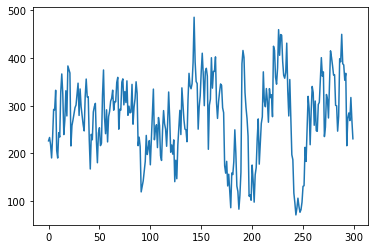

In [106]:
plt.plot(np.arange(0,300), mld_weddell_annual_mean['Weddell'])

In [107]:
mld_weddell_monthly_anom = xr.open_dataset(write_rootdir+subdir_ctrl+'MLD/mld_so_monthly_anom.nc')

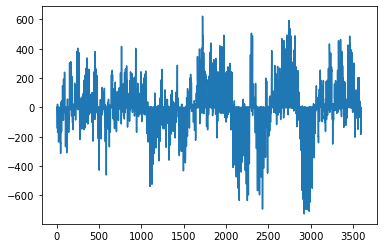

In [108]:
plt.plot(np.arange(0,3600), mld_weddell_monthly_anom['Weddell'])

### SIE

In [17]:
reg_masks = xr.open_dataset('/home/bbuchovecky/storage/so_predict_derived/regional_global_masks.nc')
sie_raw = xr.open_dataset('/home/bbuchovecky/storage/so_predict_derived/CTRL/SIE/sie_gc_so_monthly_allmetrics.nc')

In [18]:
## GLOBAL
sie_global_monthly_anom = pcs.reg_monthly_anom(sie_global_monthly_mean)
sie_global_monthly_anom.attrs['name'] = 'sie_ts_global_monthly_anom.nc'
sie_global_monthly_anom['Global'].attrs['label'] = 'Sea ice extent anomaly (m$^{2}$)'

sie_global_monthly_anom.to_netcdf('/home/bbuchovecky/storage/so_predict_derived/CTRL/SIE/sie_ts_global_monthly_anom.nc')

In [19]:
## REGIONAL
sie_so_monthly_anom = pcs.reg_monthly_anom(sie_so_monthly_mean)
sie_so_monthly_anom.attrs['name'] = 'sie_ts_so_monthly_anom.nc'
for reg in reg_masks.data_vars:
    sie_so_monthly_mean[reg].attrs['label'] = 'Sea ice extent anomaly (m$^{2}$)'
    
sie_so_monthly_anom.to_netcdf('/home/bbuchovecky/storage/so_predict_derived/CTRL/SIE/sie_ts_so_monthly_anom.nc')

### SIV

In [20]:
reg_masks = xr.open_dataset('/home/bbuchovecky/storage/so_predict_derived/regional_global_masks.nc')
siv_raw = xr.open_dataset('/home/bbuchovecky/storage/so_predict_derived/CTRL/SIV/siv_gc_so_monthly_allmetrics.nc')

In [21]:
## GLOBAL
siv_global_monthly_anom = pcs.reg_monthly_anom(siv_global_monthly_mean)
siv_global_monthly_anom.attrs['name'] = 'siv_ts_global_monthly_anom.nc'
siv_global_monthly_anom['Global'].attrs['label'] = 'Sea ice volume anomaly (m$^{3}$)'

sie_global_monthly_anom.to_netcdf('/home/bbuchovecky/storage/so_predict_derived/CTRL/SIV/siv_ts_global_monthly_anom.nc')

In [22]:
## REGIONAL
siv_so_monthly_anom = pcs.reg_monthly_anom(siv_so_monthly_mean)
siv_so_monthly_anom.attrs['name'] = 'siv_ts_so_monthly_anom.nc'
for reg in reg_masks.data_vars:
    siv_so_monthly_mean[reg].attrs['label'] = 'Sea ice volume anomaly (m$^{3}$)'
    
sie_so_monthly_anom.to_netcdf('/home/bbuchovecky/storage/so_predict_derived/CTRL/SIV/siv_ts_so_monthly_anom.nc')

## Monthly Variance

### Global

In [43]:
write_rootdir = '/home/bbuchovecky/storage/so_predict_derived/'
subdir_ctrl = 'CTRL/'

def open_anom(var, reg, time_scale):
    write_rootdir = '/home/bbuchovecky/storage/so_predict_derived/'
    subdir_ctrl = 'CTRL/'
    filename = var.lower()+'_'+reg.lower()+'_'+time_scale.lower()+'_anom.nc'
    return xr.open_dataset(write_rootdir+subdir_ctrl+var.upper()+'/'+filename)

In [44]:
sst_global_monthly_anom = open_anom('sst', 'global', 'monthly')
sss_global_monthly_anom = open_anom('sss', 'global', 'monthly')
pco2_global_monthly_anom = open_anom('pco2surf', 'global', 'monthly')
npp_global_monthly_anom = open_anom('npp', 'global', 'monthly')
cn_global_monthly_anom = open_anom('cn_inv', 'global', 'monthly')
# sie_global_monthly_anom = open_anom('sie', 'global', 'monthly')
# siv_global_monthly_anom = open_anom('siv', 'global', 'monthly')
mld_global_monthly_anom = open_anom('mld', 'global', 'monthly')

In [45]:
sst_global_monthly_var = pcs.reg_monthly_var(sst_global_monthly_anom)
sss_global_monthly_var = pcs.reg_monthly_var(sss_global_monthly_anom)
pco2_global_monthly_var = pcs.reg_monthly_var(pco2_global_monthly_anom)
npp_global_monthly_var = pcs.reg_monthly_var(npp_global_monthly_anom)
cn_global_monthly_var = pcs.reg_monthly_var(cn_global_monthly_anom)
# sie_global_monthly_var = pcs.reg_monthly_var(sie_global_monthly_anom)
# siv_global_monthly_var = pcs.reg_monthly_var(siv_global_monthly_anom)
mld_global_monthly_var = pcs.reg_monthly_var(mld_global_monthly_anom)

In [46]:
regions = sst_global_monthly_var.data_vars

for reg in regions:
    sst_global_monthly_var[reg].attrs['label'] = 'Sea surface temperature variance ($^{\circ}$C$^{2}$)'
    sss_global_monthly_var[reg].attrs['label'] = 'Sea surface salinity variance (psu$^{2}$)'
    pco2_global_monthly_var[reg].attrs['label'] = 'Surface pCO$_{2}$ variance (uatm$^{2}$)'
    npp_global_monthly_var[reg].attrs['label'] = 'Net primary production variance'
    cn_global_monthly_var[reg].attrs['label'] = 'Sea ice concentration variance'
#     sie_global_monthly_var[reg].attrs['label'] = 'Sea ice extent variance (m$^{4}$)'
#     siv_global_monthly_var[reg].attrs['label'] = 'Sea ice volume variance (m$^{6}$)'
    mld_global_monthly_var[reg].attrs['label'] = 'Mixed-layer depth variance (m$^{2}$)'

In [47]:
write_rootdir = '/home/bbuchovecky/storage/so_predict_derived/'
subdir_ctrl = 'CTRL/'

## save mean data
def save_var(ds, var, reg, time_scale):
    filename = var.lower()+'_'+reg.lower()+'_'+time_scale.lower()+'_var.nc'
    ds.to_netcdf(write_rootdir+subdir_ctrl+var.upper()+'/'+filename)

save_var(sst_global_monthly_var, 'sst', 'global', 'monthly')
save_var(sss_global_monthly_var, 'sss', 'global', 'monthly')
save_var(pco2_global_monthly_var, 'pco2surf', 'global', 'monthly')
save_var(npp_global_monthly_var, 'npp', 'global', 'monthly')
save_var(cn_global_monthly_var, 'cn_inv', 'global', 'monthly')
# save_var(sie_global_monthly_var, 'sie', 'global', 'monthly')
# save_var(siv_global_monthly_var, 'siv', 'global', 'monthly')
save_var(mld_global_monthly_var, 'mld', 'global', 'monthly')

### Southern Ocean Regions

In [48]:
write_rootdir = '/home/bbuchovecky/storage/so_predict_derived/'
subdir_ctrl = 'CTRL/'

def open_anom(var, reg, time_scale):
    write_rootdir = '/home/bbuchovecky/storage/so_predict_derived/'
    subdir_ctrl = 'CTRL/'
    filename = var.lower()+'_'+reg.lower()+'_'+time_scale.lower()+'_anom.nc'
    return xr.open_dataset(write_rootdir+subdir_ctrl+var.upper()+'/'+filename)

In [49]:
sst_so_monthly_anom = open_anom('sst', 'so', 'monthly')
sss_so_monthly_anom = open_anom('sss', 'so', 'monthly')
pco2_so_monthly_anom = open_anom('pco2surf', 'so', 'monthly')
npp_so_monthly_anom = open_anom('npp', 'so', 'monthly')
cn_so_monthly_anom = open_anom('cn_inv', 'so', 'monthly')
# sie_so_monthly_anom = open_anom('sie', 'so', 'monthly')
# siv_so_monthly_anom = open_anom('siv', 'so', 'monthly')
mld_so_monthly_anom = open_anom('mld', 'so', 'monthly')

In [50]:
sst_so_monthly_var = pcs.reg_monthly_var(sst_so_monthly_anom)
sss_so_monthly_var = pcs.reg_monthly_var(sss_so_monthly_anom)
pco2_so_monthly_var = pcs.reg_monthly_var(pco2_so_monthly_anom)
npp_so_monthly_var = pcs.reg_monthly_var(npp_so_monthly_anom)
cn_so_monthly_var = pcs.reg_monthly_var(cn_so_monthly_anom)
# sie_so_monthly_var = pcs.reg_monthly_var(sie_so_monthly_anom)
# siv_so_monthly_var = pcs.reg_monthly_var(siv_so_monthly_anom)
mld_so_monthly_var = pcs.reg_monthly_var(mld_so_monthly_anom)

In [51]:
regions = sst_so_monthly_var.data_vars

for reg in regions:
    sst_so_monthly_var[reg].attrs['label'] = 'Sea surface temperature variance ($^{\circ}$C$^{2}$)'
    sss_so_monthly_var[reg].attrs['label'] = 'Sea surface salinity variance (psu$^{2}$)'
    pco2_so_monthly_var[reg].attrs['label'] = 'Surface pCO$_{2}$ variance (uatm$^{2}$)'
    npp_so_monthly_var[reg].attrs['label'] = 'Net primary production variance'
    cn_so_monthly_var[reg].attrs['label'] = 'Sea ice concentration variance'
#     sie_so_monthly_var[reg].attrs['label'] = 'Sea ice extent variance (m$^{4}$)'
#     siv_so_monthly_var[reg].attrs['label'] = 'Sea ice volume variance (m$^{6}$)'
    mld_so_monthly_var[reg].attrs['label'] = 'Mixed-layer depth variance (m$^{2}$)'

In [52]:
write_rootdir = '/home/bbuchovecky/storage/so_predict_derived/'
subdir_ctrl = 'CTRL/'

def save_var(ds, var, reg, time_scale):
    filename = var.lower()+'_'+reg.lower()+'_'+time_scale.lower()+'_var.nc'
    ds.to_netcdf(write_rootdir+subdir_ctrl+var.upper()+'/'+filename)

save_var(sst_so_monthly_var, 'sst', 'so', 'monthly')
save_var(sss_so_monthly_var, 'sss', 'so', 'monthly')
save_var(pco2_so_monthly_var, 'pco2surf', 'so', 'monthly')
save_var(npp_so_monthly_var, 'npp', 'so', 'monthly')
save_var(cn_so_monthly_var, 'cn_inv', 'so', 'monthly')
# save_var(sie_so_monthly_var, 'sie', 'so', 'monthly')
# save_var(siv_so_monthly_var, 'siv', 'so', 'monthly')
save_var(mld_so_monthly_var, 'mld', 'so', 'monthly')

In [53]:
write_rootdir = '/home/bbuchovecky/storage/so_predict_derived/'
subdir_ctrl = 'CTRL/'

pcs.dir_inspect(write_rootdir+subdir_ctrl+'SST')

['SST_raw',
 'ocean.static.nc',
 'sst_ctrl_global_anomaly.nc',
 'sst_ctrl_global_climatology.nc',
 'sst_ctrl_global_variance.nc',
 'sst_ctrl_so_anomaly.nc',
 'sst_ctrl_so_climatology.nc',
 'sst_ctrl_so_variance.nc',
 'sst_global_annual_mean.nc',
 'sst_global_monthly_anom.nc',
 'sst_global_monthly_mean.nc',
 'sst_global_monthly_var.nc',
 'sst_so_annual_mean.nc',
 'sst_so_gridcell_metrics.nc',
 'sst_so_monthly_anom.nc',
 'sst_so_monthly_mean.nc',
 'sst_so_monthly_var.nc']

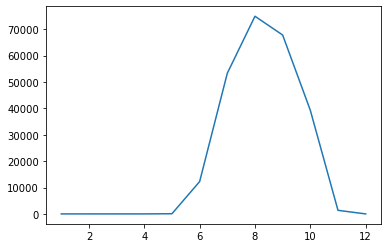

In [120]:
## check mixed-layer depth variance in the Weddell region
plt.plot(np.arange(1,13), mld_so_monthly_var['Weddell'])

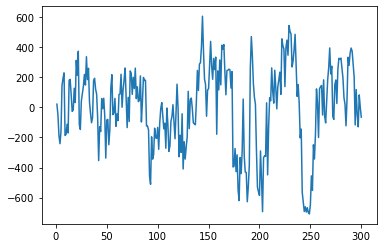

In [121]:
## compare to august anomaly data
mld_august_anom = np.zeros(300)
for m in range(3600):
    if m%12 == 7:
        mld_august_anom[int(m/12)] = mld_so_monthly_anom['Weddell'].isel(month=m)

plt.plot(np.arange(1,301), mld_august_anom)

### SIE

In [23]:
reg_masks = xr.open_dataset('/home/bbuchovecky/storage/so_predict_derived/regional_global_masks.nc')
sie_raw = xr.open_dataset('/home/bbuchovecky/storage/so_predict_derived/CTRL/SIE/sie_gc_so_monthly_allmetrics.nc')

In [24]:
## GLOBAL
sie_global_monthly_var = pcs.reg_monthly_var(sie_global_monthly_anom)
sie_global_monthly_var.attrs['name'] = 'sie_ts_global_monthly_var.nc'
sie_global_monthly_var['Global'].attrs['label'] = 'Sea ice extent variance (m$^{4}$)'

sie_global_monthly_var.to_netcdf('/home/bbuchovecky/storage/so_predict_derived/CTRL/SIE/sie_ts_global_monthly_var.nc')

In [25]:
## REGIONAL
sie_so_monthly_var = pcs.reg_monthly_var(sie_so_monthly_anom)
sie_so_monthly_var.attrs['name'] = 'sie_ts_so_monthly_var.nc'
for reg in reg_masks.data_vars:
    sie_so_monthly_mean[reg].attrs['label'] = 'Sea ice extent variance (m$^{4}$)'
    
sie_so_monthly_var.to_netcdf('/home/bbuchovecky/storage/so_predict_derived/CTRL/SIE/sie_ts_so_monthly_var.nc')

### SIV

In [26]:
reg_masks = xr.open_dataset('/home/bbuchovecky/storage/so_predict_derived/regional_global_masks.nc')
siv_raw = xr.open_dataset('/home/bbuchovecky/storage/so_predict_derived/CTRL/SIV/siv_gc_so_monthly_allmetrics.nc')

In [27]:
## GLOBAL
siv_global_monthly_var = pcs.reg_monthly_var(siv_global_monthly_anom)
siv_global_monthly_var.attrs['name'] = 'siv_ts_global_monthly_var.nc'
siv_global_monthly_var['Global'].attrs['label'] = 'Sea ice volume variance (m$^{6}$)'

siv_global_monthly_var.to_netcdf('/home/bbuchovecky/storage/so_predict_derived/CTRL/SIV/siv_ts_global_monthly_var.nc')

In [28]:
## REGIONAL
siv_so_monthly_var = pcs.reg_monthly_var(siv_so_monthly_anom)
siv_so_monthly_var.attrs['name'] = 'siv_ts_so_monthly_var.nc'
for reg in reg_masks.data_vars:
    siv_so_monthly_mean[reg].attrs['label'] = 'Sea ice volume variance (m$^{6}$)'
    
siv_so_monthly_var.to_netcdf('/home/bbuchovecky/storage/so_predict_derived/CTRL/SIV/siv_ts_so_monthly_var.nc')

# Figures
Southern Ocean and its regions

## Import Data
* Annual Mean - `[VAR]_ts_so_annual_mean.nc`
* Monthly Anomaly - `[VAR]_ts_so_monthly_anom.nc`
* Monthly Variance - `[VAR]_ts_so_monthly_var.nc`

In [6]:
write_rootdir = '/home/bbuchovecky/storage/so_predict_derived/'
subdir_ctrl = 'CTRL/'

# pcs.dir_inspect(write_rootdir+subdir_ctrl+'SST')

In [92]:
write_rootdir = '/home/bbuchovecky/storage/so_predict_derived/'
subdir_ctrl = 'CTRL/'

def open_metric(var, metric, reg, time_scale):
    write_rootdir = '/home/bbuchovecky/storage/so_predict_derived/'
    subdir_ctrl = 'CTRL/'
    filename = var.lower()+'_ts_'+reg.lower()+'_'+time_scale.lower()+'_'+metric+'.nc'
    return xr.open_dataset(write_rootdir+subdir_ctrl+var.upper()+'/'+filename)

In [93]:
sst_so_annual_mean = open_metric('sst', 'mean', 'so', 'annual')
sss_so_annual_mean = open_metric('sss', 'mean', 'so', 'annual')
pco2_so_annual_mean = open_metric('pco2surf', 'mean', 'so', 'annual')
npp_so_annual_mean = open_metric('npp', 'mean', 'so', 'annual')
cn_so_annual_mean = open_metric('cn_inv', 'mean', 'so', 'annual')
sie_so_annual_mean = open_metric('sie', 'mean', 'so', 'annual')
siv_so_annual_mean = open_metric('siv', 'mean', 'so', 'annual')
mld_so_annual_mean = open_metric('mld', 'mean', 'so', 'annual')

In [94]:
sst_so_monthly_anom = open_metric('sst', 'anom', 'so', 'monthly')
sss_so_monthly_anom = open_metric('sss', 'anom', 'so', 'monthly')
pco2_so_monthly_anom = open_metric('pco2surf', 'anom', 'so', 'monthly')
npp_so_monthly_anom = open_metric('npp', 'anom', 'so', 'monthly')
cn_so_monthly_anom = open_metric('cn_inv', 'anom', 'so', 'monthly')
sie_so_monthly_anom = open_metric('sie', 'anom', 'so', 'monthly')
siv_so_monthly_anom = open_metric('siv', 'anom', 'so', 'monthly')
mld_so_monthly_anom = open_metric('mld', 'anom', 'so', 'monthly')

In [95]:
sst_so_monthly_var = open_metric('sst', 'var', 'so', 'monthly')
sss_so_monthly_var = open_metric('sss', 'var', 'so', 'monthly')
pco2_so_monthly_var = open_metric('pco2surf', 'var', 'so', 'monthly')
npp_so_monthly_var = open_metric('npp', 'var', 'so', 'monthly')
cn_so_monthly_var = open_metric('cn_inv', 'var', 'so', 'monthly')
sie_so_monthly_var = open_metric('sie', 'var', 'so', 'monthly')
siv_so_monthly_var = open_metric('siv', 'var', 'so', 'monthly')
mld_so_monthly_var = open_metric('mld', 'var', 'so', 'monthly')

## Standard Deviation (for thresholding)

Create annual mean plot with horizontal standard deviation lines and vertical shaded regions for ensemble runs.

Use function `stdev_plot(so_annual_mean, reg, title='', ylabel='', size=(10,5))`

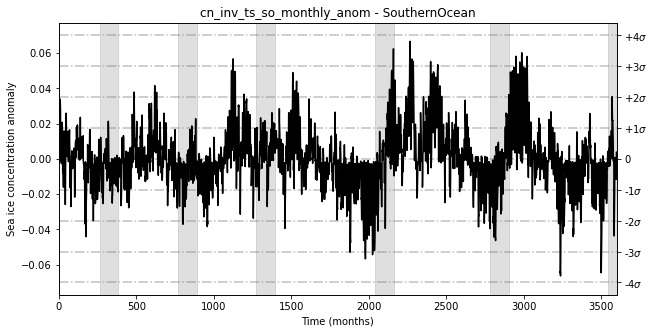

In [102]:
vis.stdev_plot(cn_so_monthly_anom, 'SouthernOcean');

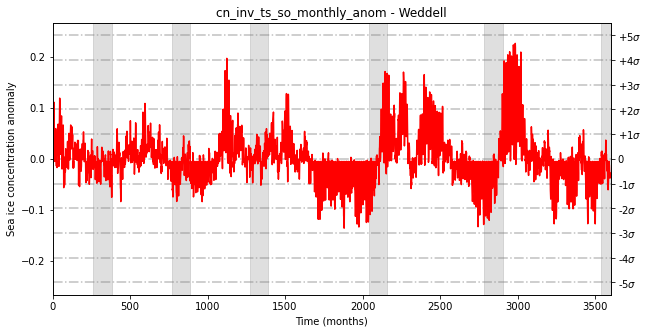

In [80]:
vis.stdev_plot(cn_so_monthly_anom, 'Weddell');

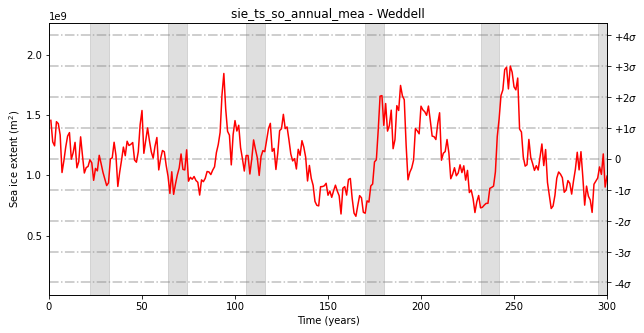

In [79]:
vis.stdev_plot(sie_so_annual_mean, 'Weddell');

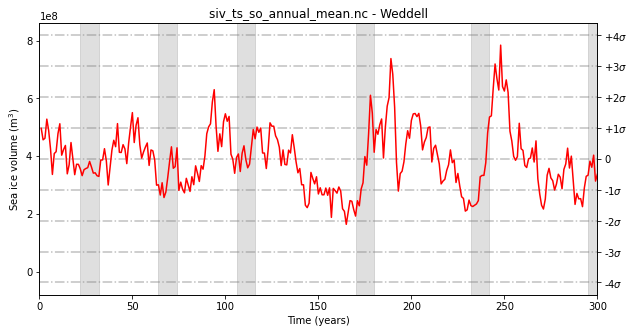

In [77]:
vis.stdev_plot(siv_so_annual_mean, 'Weddell');

## Monthly Anomaly
Use function `grid_month_anom(so_monthly_anom, reg, ylabel='', title='', size=(10,10))`

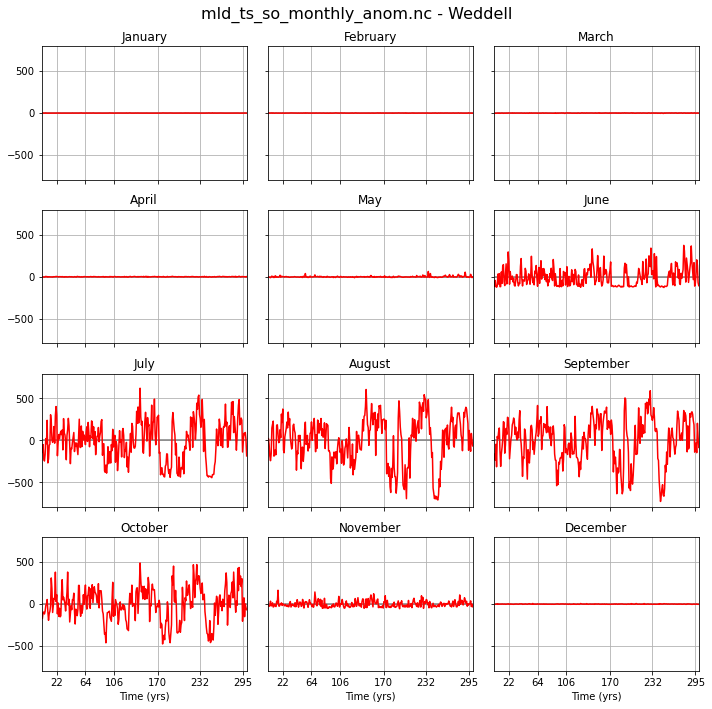

In [12]:
vis.grid_month_anom(mld_so_monthly_anom, 'Weddell')

## Monthly Variance

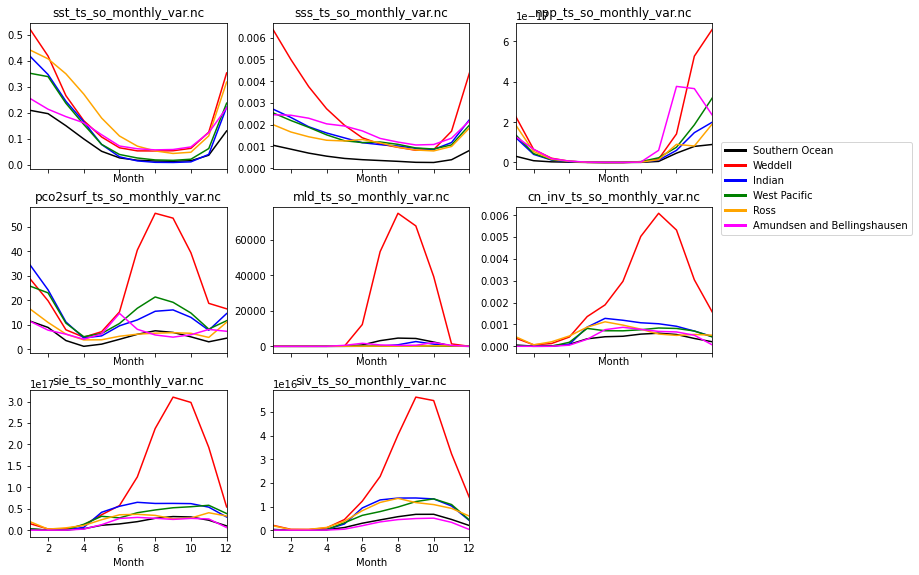

In [14]:
reg_masks = xr.open_dataset(write_rootdir+'regional_global_masks.nc')

size = (10,8)

fig,axes = plt.subplots(3, 3, figsize=size, sharex=True)

xlim = [1,12]
cmap = ['black', 'red', 'blue', 'green', 'orange', 'magenta']

all_data = [sst_so_monthly_var, sss_so_monthly_var, npp_so_monthly_var,
           pco2_so_monthly_var, mld_so_monthly_var, cn_so_monthly_var,
           sie_so_monthly_var,siv_so_monthly_var]

for p in range(9): 
    for (reg,i,title) in zip(reg_masks.data_vars, range(6), reg_masks.data_vars):
        if p > 7:
            axes[int(p/3),p%3].set_visible(False)

        else:
            axes[int(p/3),p%3].plot(all_data[p]['month'], all_data[p][reg], color=cmap[i], label=reg_masks[reg].attrs['long_name'])
            axes[int(p/3),p%3].set(title=all_data[p].attrs['name'], xlabel='Month', xlim=xlim)
    
fig.tight_layout(pad=0.75)

leg = axes[0,2].legend(bbox_to_anchor = (1.02, 0.22));
for line in leg.get_lines():
    line.set_linewidth(3.0)

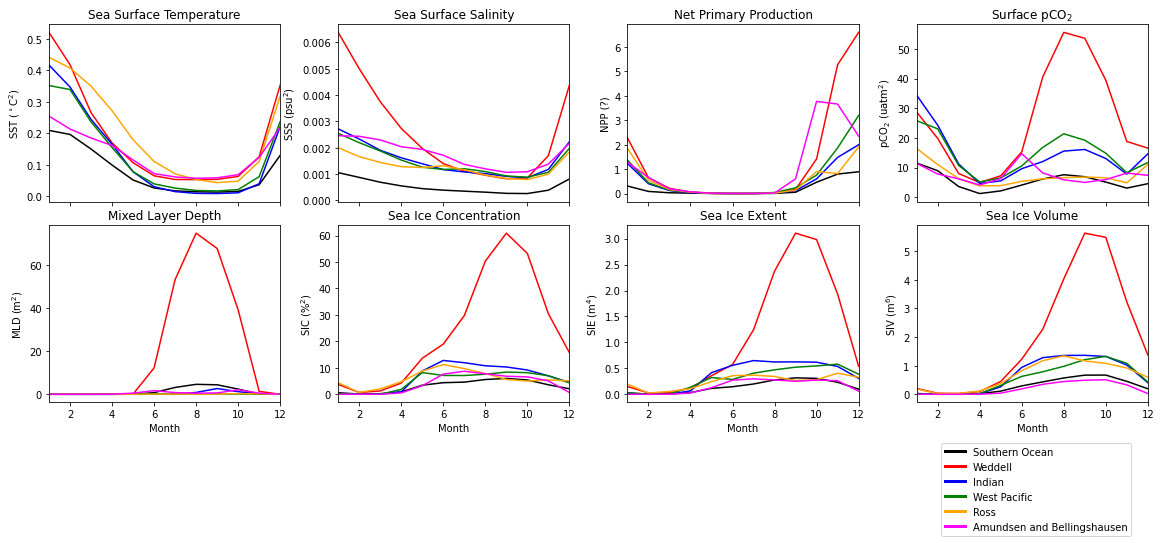

In [103]:
reg_masks = xr.open_dataset(write_rootdir+'regional_global_masks.nc')

size = (16,6)

fig,axes = plt.subplots(2, 4, figsize=size, sharex=True)

xlim=[1,12]
cmap = ['black', 'red', 'blue', 'green', 'orange', 'magenta']

all_data = [sst_so_monthly_var, sss_so_monthly_var, npp_so_monthly_var*1e17,
           pco2_so_monthly_var, mld_so_monthly_var/1000, cn_so_monthly_var*10000,
           sie_so_monthly_var/1e17,siv_so_monthly_var/1e16]

for f in range(8):
    for (reg,i) in zip(reg_masks.data_vars, range(6)):
#         if reg != 'Weddell':
        axes[int(f/4),f%4].plot(all_data[f]['month'], all_data[f][reg], color=cmap[i], label=reg_masks[reg].attrs['long_name'])
        axes[int(f/4),f%4].set(xlim=xlim, title=all_data[f].name.split('_')[0])
        
        if int(f/4) == 1:
            axes[int(f/4),f%4].set(xlabel='Month')

axes[0,0].set(title='Sea Surface Temperature', ylabel='SST ($^\circ$C$^2$)');
axes[0,1].set(title='Sea Surface Salinity', ylabel='SSS (psu$^2$)');
axes[0,2].set(title='Net Primary Production', ylabel='NPP (?)');
axes[0,3].set(title='Surface pCO$_2$', ylabel='pCO$_2$ (uatm$^2$)');
axes[1,0].set(title='Mixed Layer Depth', ylabel='MLD (m$^2$)');
axes[1,1].set(title='Sea Ice Concentration', ylabel='SIC (%$^2$)');
axes[1,2].set(title='Sea Ice Extent', ylabel='SIE (m$^4$)');
axes[1,3].set(title='Sea Ice Volume', ylabel='SIV (m$^6$)');

fig.tight_layout(pad=0.25)

leg = axes[1,3].legend(bbox_to_anchor = (0.95, -0.2));
for line in leg.get_lines():
    line.set_linewidth(3.0)

In [69]:
cn_so_monthly_anom

<xarray.Dataset>
Dimensions:        (month: 3600)
Coordinates:
  * month          (month) int64 1 2 3 4 5 6 7 ... 3595 3596 3597 3598 3599 3600
Data variables:
    SouthernOcean  (month) float64 ...
    Weddell        (month) float64 ...
    Indian         (month) float64 ...
    WestPacific    (month) float64 ...
    Ross           (month) float64 ...
    AmundBell      (month) float64 ...
Attributes:
    name:     cn_inv_ts_so_monthly_anom.nc

In [19]:
reg_masks = xr.open_dataset(write_rootdir+'regional_global_masks.nc')

def plot_var(so_monthly_var, size=(5,3)):
    fig,ax = plt.subplots(figsize=size)

    xlim = [1,12]
    cmap = ['black', 'red', 'blue', 'green', 'orange', 'magenta']

    for (reg,i,title) in zip(so_monthly_var.data_vars, range(6), reg_masks.data_vars):
        ax.plot(so_monthly_var['month'], so_monthly_var[reg], color=cmap[i], label=reg_masks[reg].attrs['long_name'])

    ax.set(title=so_monthly_var.attrs['name'], xlabel='Month', xlim=xlim)

    leg = ax.legend(bbox_to_anchor = (1.02, 1));
    for line in leg.get_lines():
        line.set_linewidth(3.0)

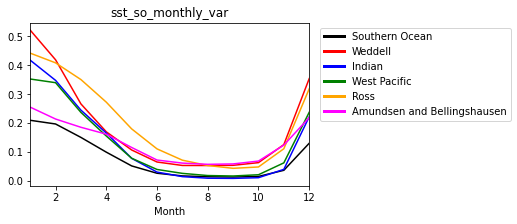

In [21]:
plot_var(sst_so_monthly_var)

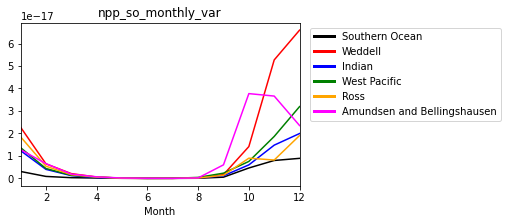

In [23]:
plot_var(npp_so_monthly_var)

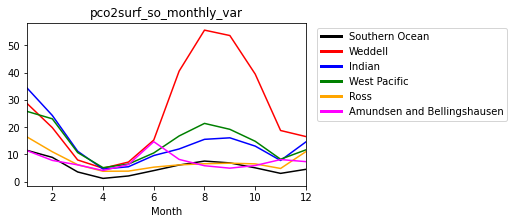

In [24]:
plot_var(pco2_so_monthly_var)

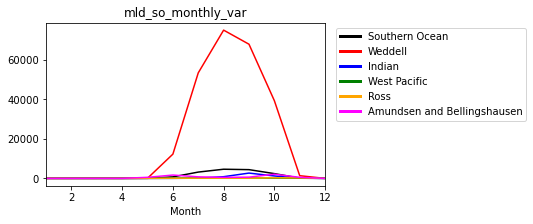

In [25]:
plot_var(mld_so_monthly_var)

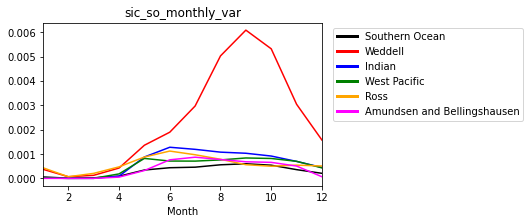

In [26]:
plot_var(cn_so_monthly_var)

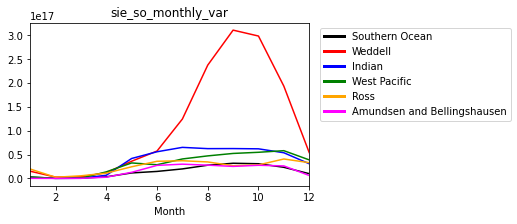

In [27]:
plot_var(sie_so_monthly_var)

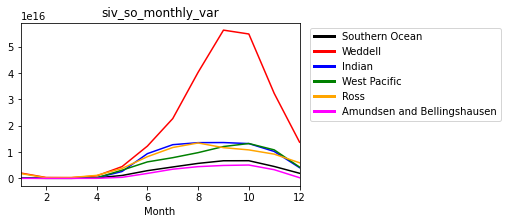

In [28]:
plot_var(siv_so_monthly_var)

# Misc

In [225]:
# ens_yrs = np.array([22,64,106,170,232,295])
# ens_mths = ens_yrs * 12

# fig,ax = plt.subplots(figsize=(10,5))
# ax.plot(np.arange(0,3600), sst_so_monthly_anom)
# ax.set(xlim=[0,3600], xticks=ens_mths, xticklabels=ens_yrs);

In [6]:
# reg_masks['SouthernOcean'].plot()
# reg_masks['Weddell'].plot(alpha=0.3)

In [4]:
# sie_metrics = xr.open_dataset(write_rootdir+subdir_ctrl+'SIE/sie_ctrl_so_timeseries.nc')
# sie_metrics['SIE_area'][0].plot()

In [5]:
# sst_gridcell = xr.open_dataset(write_rootdir+subdir_ctrl+'SST/sst_so_gridcell_metrics.nc')

In [82]:
# size = (13,10)
# # fig,axes = plt.subplots(4, 3, figsize=size, sharey=True, sharex=True)

# xlim = [1,3600]
# ls = '-'
# primary_width = 1
# secondary_width = 0.5
# cmap = ['black', 'red', 'blue', 'green', 'orange', 'magenta']


# months = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
#           'August', 'September', 'October', 'November', 'December']

# for (reg,i) in zip(so_monthly_var.data_vars, range(12)):
#     axes[int(i/3),i%3].plot(so_monthly_var['month'], so_monthly_var[reg])

# # axes[1,0].plot(np.arange(1,300), np.arange(1,300))
# # axes[1,0].set_title(months[2]);